Notebook for checking that the AOM couplings between the donor HOMO and acceptor LUMO, used to calculate the coupling between the iCT and neutral ground state, are correctly implemented.

First check is to calculate overlaps for a series of 100 interfacial 6T-PDI geometries with pyAOM and the newest X-SH version - they should be exactly the same apart from small numerical error.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [10]:
interface_overlaps_pyAOM = np.loadtxt('T6-PDI-interface-overlaps-100fs.txt')
#loading in 100 overlaps from pyAOM
interface_couplings_xsh = np.loadtxt('T6_PDI_interface_XSH_couplings_100fs.txt')
#loading in 100 couplings from 100fs X-SH run

interface_overlaps_xsh = interface_couplings_xsh/0.5
#dividing the X-SH couplings by the scaling constant (Eh) used for their calculation

Good agreement between X-SH and pyAOM overlaps found. This suggests that I have passed the correct orbital coefficients into X-SH for it to calculate the HOMO-LUMO overlap between the donor and acceptor, and that I am correctly indexing the resulting HOMO-LUMO overlap array, since I extract the overlap value from this array and insert it into the electronic Hamiltonian of X-SH.

Text(0.5, 1.0, 'Interfacial HOMO-LUOM Overlap - pyAOM vs X-SH')

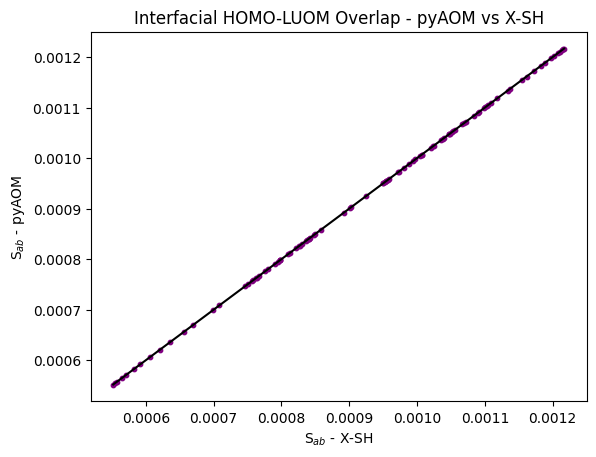

In [11]:
plt.scatter(interface_overlaps_pyAOM, interface_overlaps_xsh,s=10,color='purple')
plt.plot([min(interface_overlaps_pyAOM), max(interface_overlaps_pyAOM)],[min(interface_overlaps_xsh), max(interface_overlaps_xsh)], color='k')
plt.ylabel(r'S$_{ab}$ - pyAOM')
plt.xlabel(r'S$_{ab}$ - X-SH')
plt.title('Interfacial HOMO-LUOM Overlap - pyAOM vs X-SH')

Next check is to compare the pyAOM overlap magnitudes (could use X-SH here as well, but it would not make a difference since I showed above that they produce near-identical overlaps for a given geometry) against POD coupling magnitudes for equivalent 6T-PDI geometries. I can then fit a straight line to their scatter plot to extract the most accurate value for C_R, the AOM scaling coefficient for the HOMO-LUMO overlap.

In [12]:
#loading in overlaps for 1ps X-SH run used to sample geometries for POD - calculated the overlaps for these using pyAOM as well
interface_overlaps_pyAOM = np.loadtxt('T6-PDI-interface-overlaps-1ps.txt')
#loading in electronic couplings for same set of geometries calculated with POD
interface_couplings_pod = np.loadtxt('interface_dimer_POD_couplings_1ps.txt')*1.325 #multiplying by non-empirical scaling

In [13]:
#defining straight line that I will attempt to fit to the overlap vs POD coupling data
def linear_function(x, gradient):
    return gradient*x

#defining linear relationship between electronic coupling and overlap
def h_sc(constant, overlaps):

    return constant*overlaps

9042.768840117773


Text(0, 0.5, '|H$_{ab}$| (meV)')

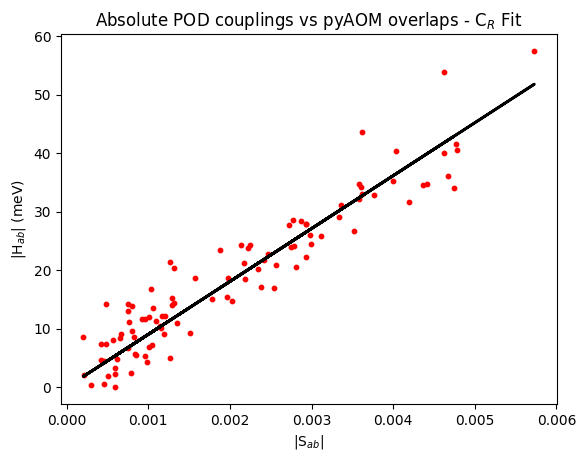

In [14]:
optimised_gradient, extra = curve_fit(linear_function, abs(interface_overlaps_pyAOM), abs(interface_couplings_pod))
#optimised array is what the coupling magnitudes would be with the fitted scaling constant
optimised_array = optimised_gradient*interface_overlaps_pyAOM
print(optimised_gradient[0])

plt.scatter(abs(interface_overlaps_pyAOM), abs(interface_couplings_pod), color='r', s=10)
plt.plot(abs(interface_overlaps_pyAOM), abs(optimised_array), color='k', linewidth=2)
plt.title(r'Absolute POD couplings vs pyAOM overlaps - C$_R$ Fit')
plt.xlabel(r'|S$_{ab}$|')
plt.ylabel(r'|H$_{ab}$| (meV)')

In [15]:
#Calculating R^2 value for H = (C_R)S with optimised C_R.
ssq = np.sum((h_sc(optimised_gradient[0], abs(interface_overlaps_pyAOM)) - abs(interface_couplings_pod))**2)

mean_coupling = np.mean(abs(interface_couplings_pod))
tss = np.sum((abs(interface_couplings_pod) - mean_coupling)**2)

r2 = 1 - ssq/tss
print(r2)

0.8857596870942018


Best fit value of C_R has been extracted and agreement between pyAOM and POD is decent. I now need to determine the sign of C_R. I plot the 1st 10 values of the |S| vs |H| plot above. I then need to plot the cube files of each 6T-PDI dimer and make sure that the FMOs' relative phases are consistent for these 10 dimers. I choose the 1st dimer's phase combo as a reference, then reverse the sign of each dimer's coupling if they don't have the reference phase. The relative phases of all 10 structures are in the folder 'interfacial-dimer-POD-cubes'. I then repeat the process for the overlaps, using the first geometry's POD calculation as a reference. After switching the signs for the molecule pairs whose phases don't match the reference, I obtain a negative correlation between the signed H and S values, which indicates that C_R < 0.

Text(0, 0.5, 'H$_{ab}$ (meV)')

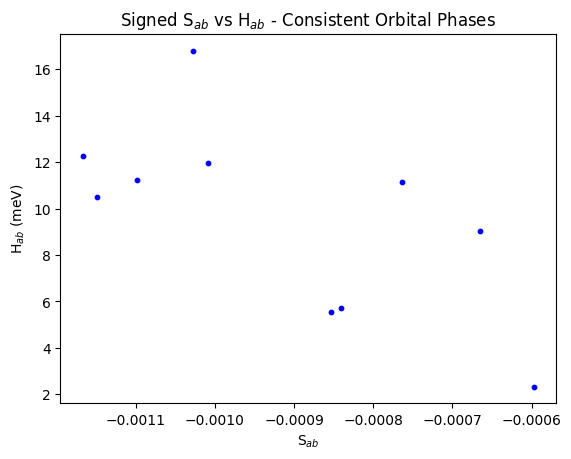

In [16]:
swapped_couplings_POD = interface_couplings_pod[:10]

#step-100 dimer has 6T phase reversed so changing sign here
swapped_couplings_POD[1] = - swapped_couplings_POD[1]
#step-200 PDI phase reversed
swapped_couplings_POD[2] = - swapped_couplings_POD[2]
#step-300 both molecules' phases reversed wrt step-0 so coupling sign unchanged
#step-400 both phases reversed so same as above
#step-500 neither molecule's phase has changed wrt step-0
#step-600 neither phase changed wrt step-600
#step700 6T phase reversed wrt step-0
swapped_couplings_POD[7] = - swapped_couplings_POD[7]
#step-800 both phases the same as in step-0
#step-900 6T phases reversed wrt step-0 so swapping sign
swapped_couplings_POD[-1] = - swapped_couplings_POD[-1]

#Now having to the same thing for the pyAOM orbitals overlapping, phases should be consistent with step-0 from POD
#-----------------------------------------------------------------------------------------------------------------
# all overlaps reversed in sign since 6T phase is opposite of step-0 POD calculation
swapped_overlaps_pyAOM = [-overlap for overlap in interface_overlaps_pyAOM[:10]]

plt.scatter(swapped_overlaps_pyAOM, swapped_couplings_POD, color='b', s=10)
plt.title(r'Signed S$_{ab}$ vs H$_{ab}$ - Consistent Orbital Phases')
plt.xlabel(r'S$_{ab}$')
plt.ylabel(r'H$_{ab}$ (meV)')
#plt.ylim([0,20])